This file consists of the code for the CS7150: Deep Learning Project's Multimodal Classifiers.

In [2]:
!pip install -U datasets evaluate

In [3]:
from google.colab import userdata

# Lib Configs
# Invaliate this before sharing
SEED = 42
HF_TOKEN = userdata.get('HF_TOKEN')

# ML Configs
TRAIN_TEST_SPLIT=0.8

In [4]:
from huggingface_hub import login

login(token=HF_TOKEN)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from torchvision.transforms import ToTensor

from tqdm import tqdm

# Load MNIST from Hugging Face

# dataset = load_dataset("kishore-s-15/mnist-with-captions")
dataset = load_dataset("kishore-s-15/mnist-qwen2.5-2B-captions")
dataset = dataset["train"].train_test_split(test_size=TRAIN_TEST_SPLIT, seed=SEED)

In [6]:
dataset["train"]["caption"][:5]

["The handwritten digit image depicts a '3'.",
 "The handwritten digit image depicts a '4'.",
 "The handwritten digit image depicts a '2'.",
 "The handwritten digit image depicts a '6'.",
 "The handwritten digit image depicts a '4'."]

In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [8]:
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader

def simple_tokenizer(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokens = text.lower().strip().split()  # space-based split
    return tokens

def build_vocab(texts, min_freq=5):
    counter = Counter()
    for text in texts:
        tokens = simple_tokenizer(text)
        counter.update(tokens)

    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

In [9]:
import numpy as np

class MNISTTorchDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, vocab, max_len=7, transform=None):
        self.dataset = hf_dataset

        self.vocab = vocab
        self.max_len = max_len

        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        image = item["image"]
        label = item["label"]

        if self.transform:
            image = self.transform(image)

        caption = item["caption"]
        tokens = simple_tokenizer(caption)
        token_ids = [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]
        token_ids = token_ids[:self.max_len]
        pad_len = self.max_len - len(token_ids)
        token_ids += [self.vocab["<PAD>"]] * pad_len

        return image, torch.tensor(token_ids), label

captions = [d['caption'] for d in dataset['train']]  # Or your train split
vocab = build_vocab(captions, min_freq=2)

train_dataset = MNISTTorchDataset(dataset["train"], vocab, transform=transform)
test_dataset = MNISTTorchDataset(dataset["test"], vocab, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [10]:
vocab

{'<PAD>': 0,
 '<UNK>': 1,
 'the': 2,
 'handwritten': 3,
 'digit': 4,
 'image': 5,
 'depicts': 6,
 'a': 7,
 '3': 8,
 '4': 9,
 '2': 10,
 '6': 11,
 '9': 12,
 '5': 13,
 '8': 14,
 '7': 15,
 '0': 16,
 '1': 17}

In [11]:
# Cross-Attention based Multimodal model

import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageEncoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)  # [B, latent_dim]

class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, latent_dim=256, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, latent_dim, batch_first=True)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        return h.squeeze(0)  # [B, latent_dim]

class BidirectionalCrossModalFusion(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.attn_img_to_txt = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=4, batch_first=True)
        self.attn_txt_to_img = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=4, batch_first=True)

    def forward(self, img_feat, txt_feat):
        img_feat = img_feat.unsqueeze(1)  # [B, 1, D]
        txt_feat = txt_feat.unsqueeze(1)  # [B, 1, D]

        # Image attends to text
        img_attended, _ = self.attn_img_to_txt(img_feat, txt_feat, txt_feat)  # Query=img, Key/Value=text

        # Text attends to image
        txt_attended, _ = self.attn_txt_to_img(txt_feat, img_feat, img_feat)

        # Aggregate
        fused = torch.cat([img_attended, txt_attended], dim=1)  # [B, 2, D]
        return fused.mean(dim=1)  # Final Z: [B, D]


class ClassifierHead(nn.Module):
    def __init__(self, latent_dim=256, num_classes=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, z):
        return self.classifier(z)

class ImageDecoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # (14×14)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # (28×28)
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),  # output size remains 28x28
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 7, 7)
        return self.deconv(x)

class TextDecoder(nn.Module):
    def __init__(self, latent_dim=256, vocab_size=500, embed_dim=128, max_len=7):
        super().__init__()
        self.latent_to_hidden = nn.Linear(latent_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True)
        self.output = nn.Linear(embed_dim, vocab_size)
        self.max_len = max_len

    def forward(self, z):
        # Repeat z for sequence generation
        z_exp = self.latent_to_hidden(z).unsqueeze(1).repeat(1, self.max_len, 1)
        output, _ = self.lstm(z_exp)
        return self.output(output)  # [B, max_len, vocab_size]

class UnifiedModalModel(nn.Module):
    def __init__(self, vocab_size, latent_dim=256, max_len=7):
        super().__init__()
        self.image_encoder = ImageEncoder(latent_dim)
        self.text_encoder = TextEncoder(vocab_size, latent_dim=latent_dim)
        self.fusion = BidirectionalCrossModalFusion(latent_dim)
        self.classifier = ClassifierHead(latent_dim)
        self.image_decoder = ImageDecoder(latent_dim)
        self.text_decoder = TextDecoder(latent_dim, vocab_size, max_len=max_len)

    def forward(self, image, text):
        img_z = self.image_encoder(image)
        txt_z = self.text_encoder(text)
        z = self.fusion(img_z, txt_z)
        class_logits = self.classifier(z)
        recon_img = self.image_decoder(z)
        recon_text = self.text_decoder(z)
        return z, class_logits, recon_img, recon_text, img_z, txt_z


In [12]:
# Simple concat-fusion based model. Comment the above cell and uncomment this if you want to run the other model.

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ImageEncoder(nn.Module):
#     def __init__(self, latent_dim=256):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
#             nn.ReLU(),
#             nn.Flatten()
#         )
#         self.fc = nn.Linear(64 * 7 * 7, latent_dim)

#     def forward(self, x):
#         x = self.conv(x)
#         return self.fc(x)  # [B, latent_dim]

# class TextEncoder(nn.Module):
#     def __init__(self, vocab_size, embed_dim=128, latent_dim=256, pad_idx=0):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
#         self.lstm = nn.LSTM(embed_dim, latent_dim, batch_first=True)

#     def forward(self, x):
#         emb = self.embedding(x)
#         _, (h, _) = self.lstm(emb)
#         return h.squeeze(0)  # [B, latent_dim]

# class SimpleConcatenationFusion(nn.Module):
#     def __init__(self, latent_dim=256):
#         super().__init__()
#         # After concatenation, reduce dimensions back to latent_dim
#         self.projection = nn.Linear(latent_dim * 2, latent_dim)

#     def forward(self, img_feat, txt_feat):
#         # Simple concatenation of image and text features
#         concat_feat = torch.cat([img_feat, txt_feat], dim=1)  # [B, 2*D]

#         # Project back to original latent dimension
#         fused = self.projection(concat_feat)  # [B, D]

#         return fused

# class ClassifierHead(nn.Module):
#     def __init__(self, latent_dim=256, num_classes=10):
#         super().__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(latent_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, z):
#         return self.classifier(z)

# class ImageDecoder(nn.Module):
#     def __init__(self, latent_dim=256):
#         super().__init__()
#         self.fc = nn.Linear(latent_dim, 128 * 7 * 7)
#         self.deconv = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # (14×14)
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # (28×28)
#             nn.ReLU(),
#             nn.Conv2d(32, 1, 3, padding=1),  # output size remains 28x28
#             nn.Sigmoid()
#         )

#     def forward(self, z):
#         x = self.fc(z).view(-1, 128, 7, 7)
#         return self.deconv(x)

# class TextDecoder(nn.Module):
#     def __init__(self, latent_dim=256, vocab_size=500, embed_dim=128, max_len=7):
#         super().__init__()
#         self.latent_to_hidden = nn.Linear(latent_dim, embed_dim)
#         self.lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True)
#         self.output = nn.Linear(embed_dim, vocab_size)
#         self.max_len = max_len

#     def forward(self, z):
#         # Repeat z for sequence generation
#         z_exp = self.latent_to_hidden(z).unsqueeze(1).repeat(1, self.max_len, 1)
#         output, _ = self.lstm(z_exp)
#         return self.output(output)  # [B, max_len, vocab_size]

# class UnifiedModalModel(nn.Module):
#     def __init__(self, vocab_size, latent_dim=256, max_len=7):
#         super().__init__()
#         self.image_encoder = ImageEncoder(latent_dim)
#         self.text_encoder = TextEncoder(vocab_size, latent_dim=latent_dim)
#         self.fusion = SimpleConcatenationFusion(latent_dim)
#         self.classifier = ClassifierHead(latent_dim)
#         self.image_decoder = ImageDecoder(latent_dim)
#         self.text_decoder = TextDecoder(latent_dim, vocab_size, max_len=max_len)

#     def forward(self, image, text):
#         img_z = self.image_encoder(image)
#         txt_z = self.text_encoder(text)
#         z = self.fusion(img_z, txt_z)
#         class_logits = self.classifier(z)
#         recon_img = self.image_decoder(z)
#         recon_text = self.text_decoder(z)
#         return z, class_logits, recon_img, recon_text, img_z, txt_z

In [12]:
def contrastive_loss(img_embed, txt_embed, temperature=0.1):
    img_embed = F.normalize(img_embed, dim=1)
    txt_embed = F.normalize(txt_embed, dim=1)
    logits = img_embed @ txt_embed.T / temperature
    labels = torch.arange(logits.size(0)).to(img_embed.device)
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.T, labels)
    return (loss_i2t + loss_t2i) / 2

In [13]:
def mask_modalities(image, text, p_img=0.3, p_txt=0.3, pad_token=0):
    """
    Randomly mask image and/or text while preserving data types.
    """
    B = image.size(0)

    img_mask = torch.bernoulli(torch.full((B,), 1 - p_img)).to(image.device)  # 1=keep, 0=mask
    txt_mask = torch.bernoulli(torch.full((B,), 1 - p_txt)).to(text.device)

    img_mask_exp = img_mask.view(-1, 1, 1, 1)
    masked_image = image * img_mask_exp

    txt_mask_exp = txt_mask.view(-1, 1).bool()
    masked_text = torch.where(txt_mask_exp, text, torch.full_like(text, pad_token))

    return masked_image, masked_text, img_mask, txt_mask

In [14]:
def train(model, dataloader, optimizer, criterion_cls, criterion_img, criterion_txt,
          alpha1=1.0, alpha2=1.0, alpha3=1.0, p_img=0.3, p_txt=0.3, device="cuda"):
    model.train()
    total_loss = 0
    total_cls, total_img, total_txt, total_contrast = 0, 0, 0, 0

    pbar = tqdm(dataloader, desc="Training")
    for image, text, label in pbar:
        image, text, label = image.to(device), text.to(device), label.to(device)

        # Random modality masking
        masked_img, masked_txt, img_mask, txt_mask = mask_modalities(image, text, p_img=0.3, p_txt=0.3, pad_token=vocab["<PAD>"])

        optimizer.zero_grad()
        z, class_logits, recon_img, recon_text, img_embed, txt_embed = model(masked_img, masked_txt)

        # Compute losses
        loss_cls = criterion_cls(class_logits, label)
        loss_img = criterion_img(recon_img, image)
        recon_text = recon_text.permute(0, 2, 1)
        loss_txt = criterion_txt(recon_text, text)
        loss_contrast = contrastive_loss(img_embed, txt_embed)

        loss = alpha1 * loss_cls + alpha2 * (loss_img + loss_txt) + alpha3 * loss_contrast
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls += loss_cls.item()
        total_img += loss_img.item()
        total_txt += loss_txt.item()
        total_contrast += loss_contrast.item()

        pbar.set_postfix({
            "Total": f"{loss.item():.4f}",
            "Cls": f"{loss_cls.item():.4f}",
            "ImgRec": f"{loss_img.item():.4f}",
            "TxtRec": f"{loss_txt.item():.4f}",
            "Contrast": f"{loss_contrast.item():.4f}",
            "MaskImg": f"{(1 - img_mask.mean().item()):.2f}",
            "MaskTxt": f"{(1 - txt_mask.mean().item()):.2f}"
        })

    return total_loss / len(dataloader)


In [15]:
def evaluate(model, dataloader, criterion_cls, criterion_img, criterion_txt, device="cuda"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    total_cls, total_img, total_txt, total_contrast = 0, 0, 0, 0

    pbar = tqdm(dataloader, desc="Evaluating")
    with torch.no_grad():
        for image, text, label in pbar:
            image, text, label = image.to(device), text.to(device), label.to(device)

            z, class_logits, recon_img, recon_text, img_embed, txt_embed = model(image, text)

            loss_cls = criterion_cls(class_logits, label)
            loss_img = criterion_img(recon_img, image)
            recon_text = recon_text.permute(0, 2, 1)
            loss_txt = criterion_txt(recon_text, text)
            loss_contrast = contrastive_loss(img_embed, txt_embed)

            loss = loss_cls + loss_img + loss_txt + loss_contrast

            # Accumulate
            total_loss += loss.item()
            total_cls += loss_cls.item()
            total_img += loss_img.item()
            total_txt += loss_txt.item()
            total_contrast += loss_contrast.item()

            preds = class_logits.argmax(dim=1)
            correct += (preds == label).sum().item()
            total += label.size(0)

            # Update progress bar
            pbar.set_postfix({
                "Total": f"{loss.item():.4f}",
                "Cls": f"{loss_cls.item():.4f}",
                "ImgRec": f"{loss_img.item():.4f}",
                "TxtRec": f"{loss_txt.item():.4f}",
                "Contrast": f"{loss_contrast.item():.4f}"
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [16]:
import torch.optim as optim

device = "cuda"

model = UnifiedModalModel(vocab_size=len(vocab), latent_dim=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

criterion_cls = nn.CrossEntropyLoss()
criterion_img = nn.MSELoss()
criterion_txt = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])

In [17]:
for epoch in range(5):
    train_loss = train(model, train_loader, optimizer, criterion_cls, criterion_img, criterion_txt,
                       alpha1=0.3, alpha2=0.3, alpha3=0.3, device=device)
    val_loss, val_acc = evaluate(model, test_loader, criterion_cls, criterion_img, criterion_txt, device=device)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}")


Evaluating: 100%|██████████| 750/750 [00:48<00:00, 15.45it/s, Total=3.6286, Cls=0.2544, ImgRec=0.0360, TxtRec=0.5213, Contrast=2.8169]


Epoch 1: Train Loss=1.8004 | Val Loss=3.5207 | Val Acc=0.9528


Evaluating: 100%|██████████| 750/750 [00:49<00:00, 15.15it/s, Total=2.9374, Cls=0.1916, ImgRec=0.0324, TxtRec=0.1030, Contrast=2.6104]


Epoch 2: Train Loss=1.2874 | Val Loss=2.9245 | Val Acc=0.9665


Evaluating: 100%|██████████| 750/750 [00:48<00:00, 15.44it/s, Total=2.7974, Cls=0.2198, ImgRec=0.0308, TxtRec=0.0338, Contrast=2.5130]


Epoch 3: Train Loss=1.2070 | Val Loss=2.7870 | Val Acc=0.9734


Evaluating: 100%|██████████| 750/750 [00:49<00:00, 15.09it/s, Total=2.7008, Cls=0.1463, ImgRec=0.0282, TxtRec=0.0190, Contrast=2.5073]


Epoch 4: Train Loss=1.1780 | Val Loss=2.7303 | Val Acc=0.9761


Evaluating: 100%|██████████| 750/750 [00:47<00:00, 15.67it/s, Total=2.7333, Cls=0.1539, ImgRec=0.0276, TxtRec=0.0266, Contrast=2.5253]

Epoch 5: Train Loss=1.1650 | Val Loss=2.7237 | Val Acc=0.9755


In [26]:
def decode_caption(token_ids, vocab):
    inv_vocab = {idx: word for word, idx in vocab.items()}
    tokens = [inv_vocab.get(idx, "<UNK>") for idx in token_ids]
    return " ".join([tok for tok in tokens if tok not in ["<PAD>"]])

In [27]:
def generate_image_from_text(model, text_tensor, device="cuda"):
    model.eval()
    with torch.no_grad():
        text_tensor = text_tensor.to(device)
        txt_embed = model.text_encoder(text_tensor)
        dummy_img_embed = torch.zeros_like(txt_embed)
        fused_z = model.fusion(dummy_img_embed, txt_embed)
        gen_img = model.image_decoder(fused_z)
    return gen_img


In [28]:
def generate_text_from_image(model, image_tensor, device="cuda"):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        img_embed = model.image_encoder(image_tensor)
        dummy_txt_embed = torch.zeros_like(img_embed)
        fused_z = model.fusion(img_embed, dummy_txt_embed)
        gen_text_logits = model.text_decoder(fused_z)  # [B, max_len, vocab]
        gen_text_ids = gen_text_logits.argmax(dim=-1)  # [B, max_len]
    return gen_text_ids


Original Label: 7


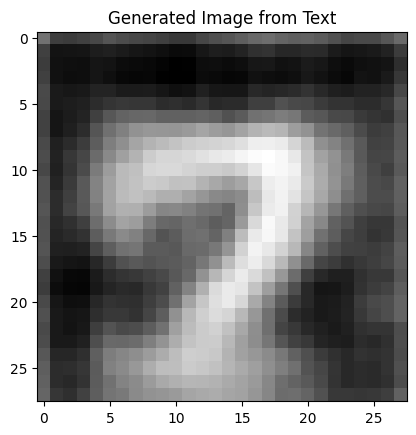

Generated Text: the handwritten digit image depicts a 7


In [29]:
import matplotlib.pyplot as plt

# Get one sample from test set
sample_img, sample_text, sample_label = test_dataset[1]

print(f"Original Label: {sample_label}")

sample_text = sample_text.unsqueeze(0)  # [1, seq_len]
gen_image = generate_image_from_text(model, sample_text, device)
plt.imshow(gen_image.squeeze(0).cpu().squeeze(0), cmap="gray")
plt.title("Generated Image from Text")
plt.show()

sample_img = sample_img.unsqueeze(0)  # [1, 1, 28, 28]
gen_text_ids = generate_text_from_image(model, sample_img, device)
generated_text = decode_caption(gen_text_ids[0].cpu().tolist(), vocab)
print("Generated Text:", generated_text)

In [30]:
def visualize_all_digits(model, dataset, vocab, device="cuda", samples_per_digit=3):
    from collections import defaultdict
    digit_samples = defaultdict(list)

    # First collect enough samples per digit
    for i in range(len(dataset)):
        img, txt, label = dataset[i]
        if len(digit_samples[label]) < samples_per_digit:
            digit_samples[label].append((img, txt))
        if all(len(v) == samples_per_digit for v in digit_samples.values()):
            break

    model.eval()
    fig, axs = plt.subplots(10 * samples_per_digit, 7, figsize=(20, 25))
    row_idx = 0

    with torch.no_grad():
        for digit in range(10):
            for img, txt in digit_samples[digit]:
                image = img.unsqueeze(0).to(device)
                text = txt.unsqueeze(0).to(device)

                img_embed = model.image_encoder(image)
                txt_embed = model.text_encoder(text)

                # Scenario: both modalities
                z_both = model.fusion(img_embed, txt_embed)
                recon_img_both = model.image_decoder(z_both).squeeze().cpu()
                recon_txt_both = model.text_decoder(z_both).argmax(dim=-1)[0].cpu()

                # Scenario: only image
                z_img = model.fusion(img_embed, torch.zeros_like(txt_embed))
                recon_img_imgonly = model.image_decoder(z_img).squeeze().cpu()
                recon_txt_imgonly = model.text_decoder(z_img).argmax(dim=-1)[0].cpu()

                # Scenario: only text
                z_txt = model.fusion(torch.zeros_like(img_embed), txt_embed)
                recon_img_txtonly = model.image_decoder(z_txt).squeeze().cpu()
                recon_txt_txtonly = model.text_decoder(z_txt).argmax(dim=-1)[0].cpu()

                # Row visuals
                axs[row_idx][0].imshow(img.squeeze().cpu(), cmap="gray")
                axs[row_idx][0].set_title("Original")

                axs[row_idx][1].imshow(recon_img_both, cmap="gray")
                axs[row_idx][1].set_title("Recon (Both)")

                axs[row_idx][2].imshow(recon_img_txtonly, cmap="gray")
                axs[row_idx][2].set_title("Recon (Text Only)")

                axs[row_idx][3].imshow(recon_img_imgonly, cmap="gray")
                axs[row_idx][3].set_title("Recon (Image Only)")

                axs[row_idx][4].text(0.5, 0.5, decode_caption(txt.cpu().tolist(), vocab), ha='center', va='center', wrap=True)
                axs[row_idx][4].set_title("Original Caption")

                axs[row_idx][5].text(0.5, 0.5, decode_caption(recon_txt_both.cpu().tolist(), vocab), ha='center', va='center', wrap=True)
                axs[row_idx][5].set_title("Gen (Both)")

                axs[row_idx][6].text(0.5, 0.5, decode_caption(recon_txt_imgonly.cpu().tolist(), vocab), ha='center', va='center', wrap=True)
                axs[row_idx][6].set_title("Gen (Image Only)")

                for col in range(7):
                    axs[row_idx][col].axis("off")

                row_idx += 1

    plt.tight_layout()
    plt.show()


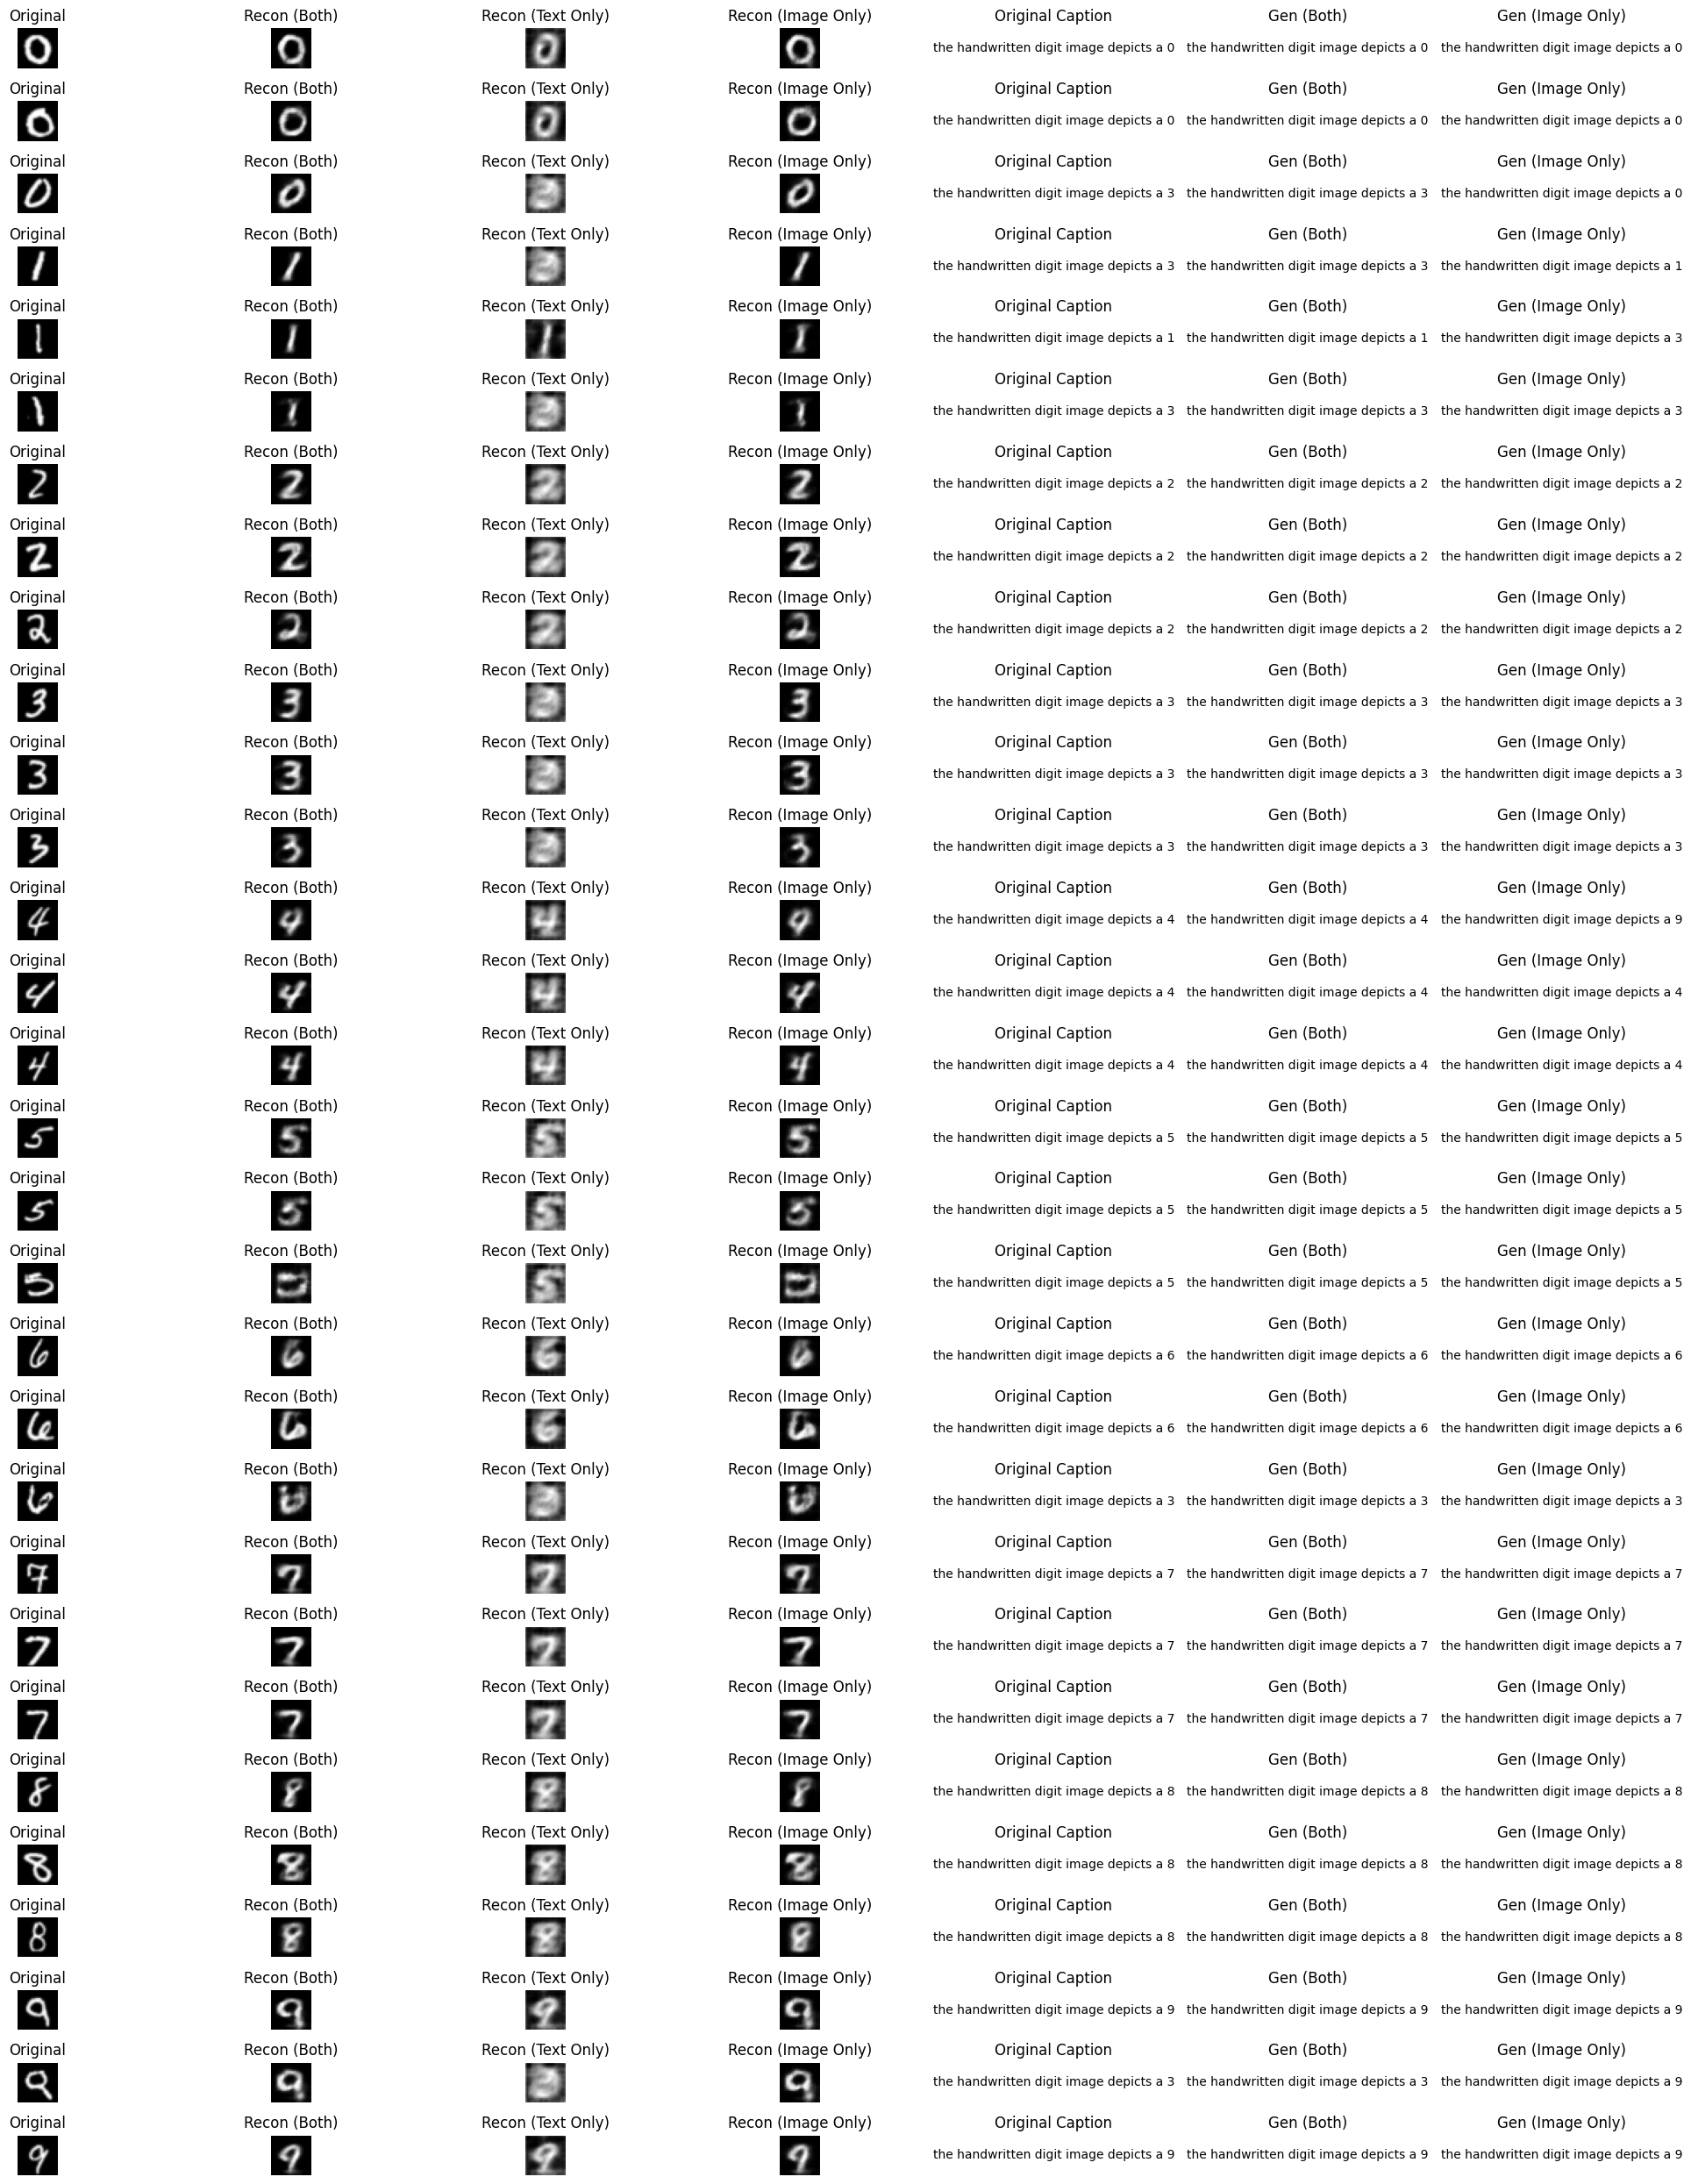

In [31]:
visualize_all_digits(model, test_dataset, vocab, device=device, samples_per_digit=3)

In [59]:
def visualize_all_digits_grouped_plots(model, dataset, vocab, device="cuda"):
    import matplotlib.pyplot as plt

    wanted_labels = {0, 3, 4, 5, 9}
    digit_samples = {}
    for i in range(len(dataset)):
        img, txt, label = dataset[i]
        if label not in wanted_labels:
            digit_samples[label] = (img, txt)
        if len(digit_samples) == len(wanted_labels):
            break

    model.eval()

    # ==== IMAGE RECONSTRUCTION PLOT ====
    fig_img, axs_img = plt.subplots(len(wanted_labels), 4, figsize=(16, 25))

    # ==== TEXT GENERATION PLOT ====
    fig_txt, axs_txt = plt.subplots(len(wanted_labels), 3, figsize=(12, 25))

    with torch.no_grad():
        for row, digit in enumerate(sorted(digit_samples.keys())):
            img, txt = digit_samples[digit]
            image = img.unsqueeze(0).to(device)
            text = txt.unsqueeze(0).to(device)

            img_embed = model.image_encoder(image)
            txt_embed = model.text_encoder(text)

            z_both = model.fusion(img_embed, txt_embed)
            z_img = model.fusion(img_embed, torch.zeros_like(txt_embed))
            z_txt = model.fusion(torch.zeros_like(img_embed), txt_embed)

            # ==== Image Reconstructions ====
            recon_img_both = model.image_decoder(z_both).squeeze().cpu()
            recon_img_imgonly = model.image_decoder(z_img).squeeze().cpu()
            recon_img_txtonly = model.image_decoder(z_txt).squeeze().cpu()

            axs_img[row][0].imshow(img.squeeze().cpu(), cmap="gray")
            axs_img[row][0].set_title("Original")

            axs_img[row][1].imshow(recon_img_both, cmap="gray")
            axs_img[row][1].set_title("Recon (Both)")

            axs_img[row][2].imshow(recon_img_txtonly, cmap="gray")
            axs_img[row][2].set_title("Recon (Text Only)")

            axs_img[row][3].imshow(recon_img_imgonly, cmap="gray")
            axs_img[row][3].set_title("Recon (Image Only)")

            for ax in axs_img[row]:
                ax.axis("off")

            # ==== Text Generations ====
            recon_txt_both = model.text_decoder(z_both).argmax(dim=-1)[0].cpu()
            recon_txt_imgonly = model.text_decoder(z_img).argmax(dim=-1)[0].cpu()

            axs_txt[row][0].text(0.5, 0.5, decode_caption(txt.cpu().tolist(), vocab), ha='center', va='center', wrap=True)
            axs_txt[row][0].set_title("Original Caption")

            axs_txt[row][1].text(0.5, 0.5, decode_caption(recon_txt_both.cpu().tolist(), vocab), ha='center', va='center', wrap=True)
            axs_txt[row][1].set_title("Gen (Both)")

            axs_txt[row][2].text(0.5, 0.5, decode_caption(recon_txt_imgonly.cpu().tolist(), vocab), ha='center', va='center', wrap=True)
            axs_txt[row][2].set_title("Gen (Image Only)")

            for ax in axs_txt[row]:
                ax.axis("off")

    fig_img.suptitle("Image Reconstructions for Digits", fontsize=16)
    fig_txt.suptitle("Caption Generations for Digits", fontsize=16)

    plt.tight_layout()
    plt.show()


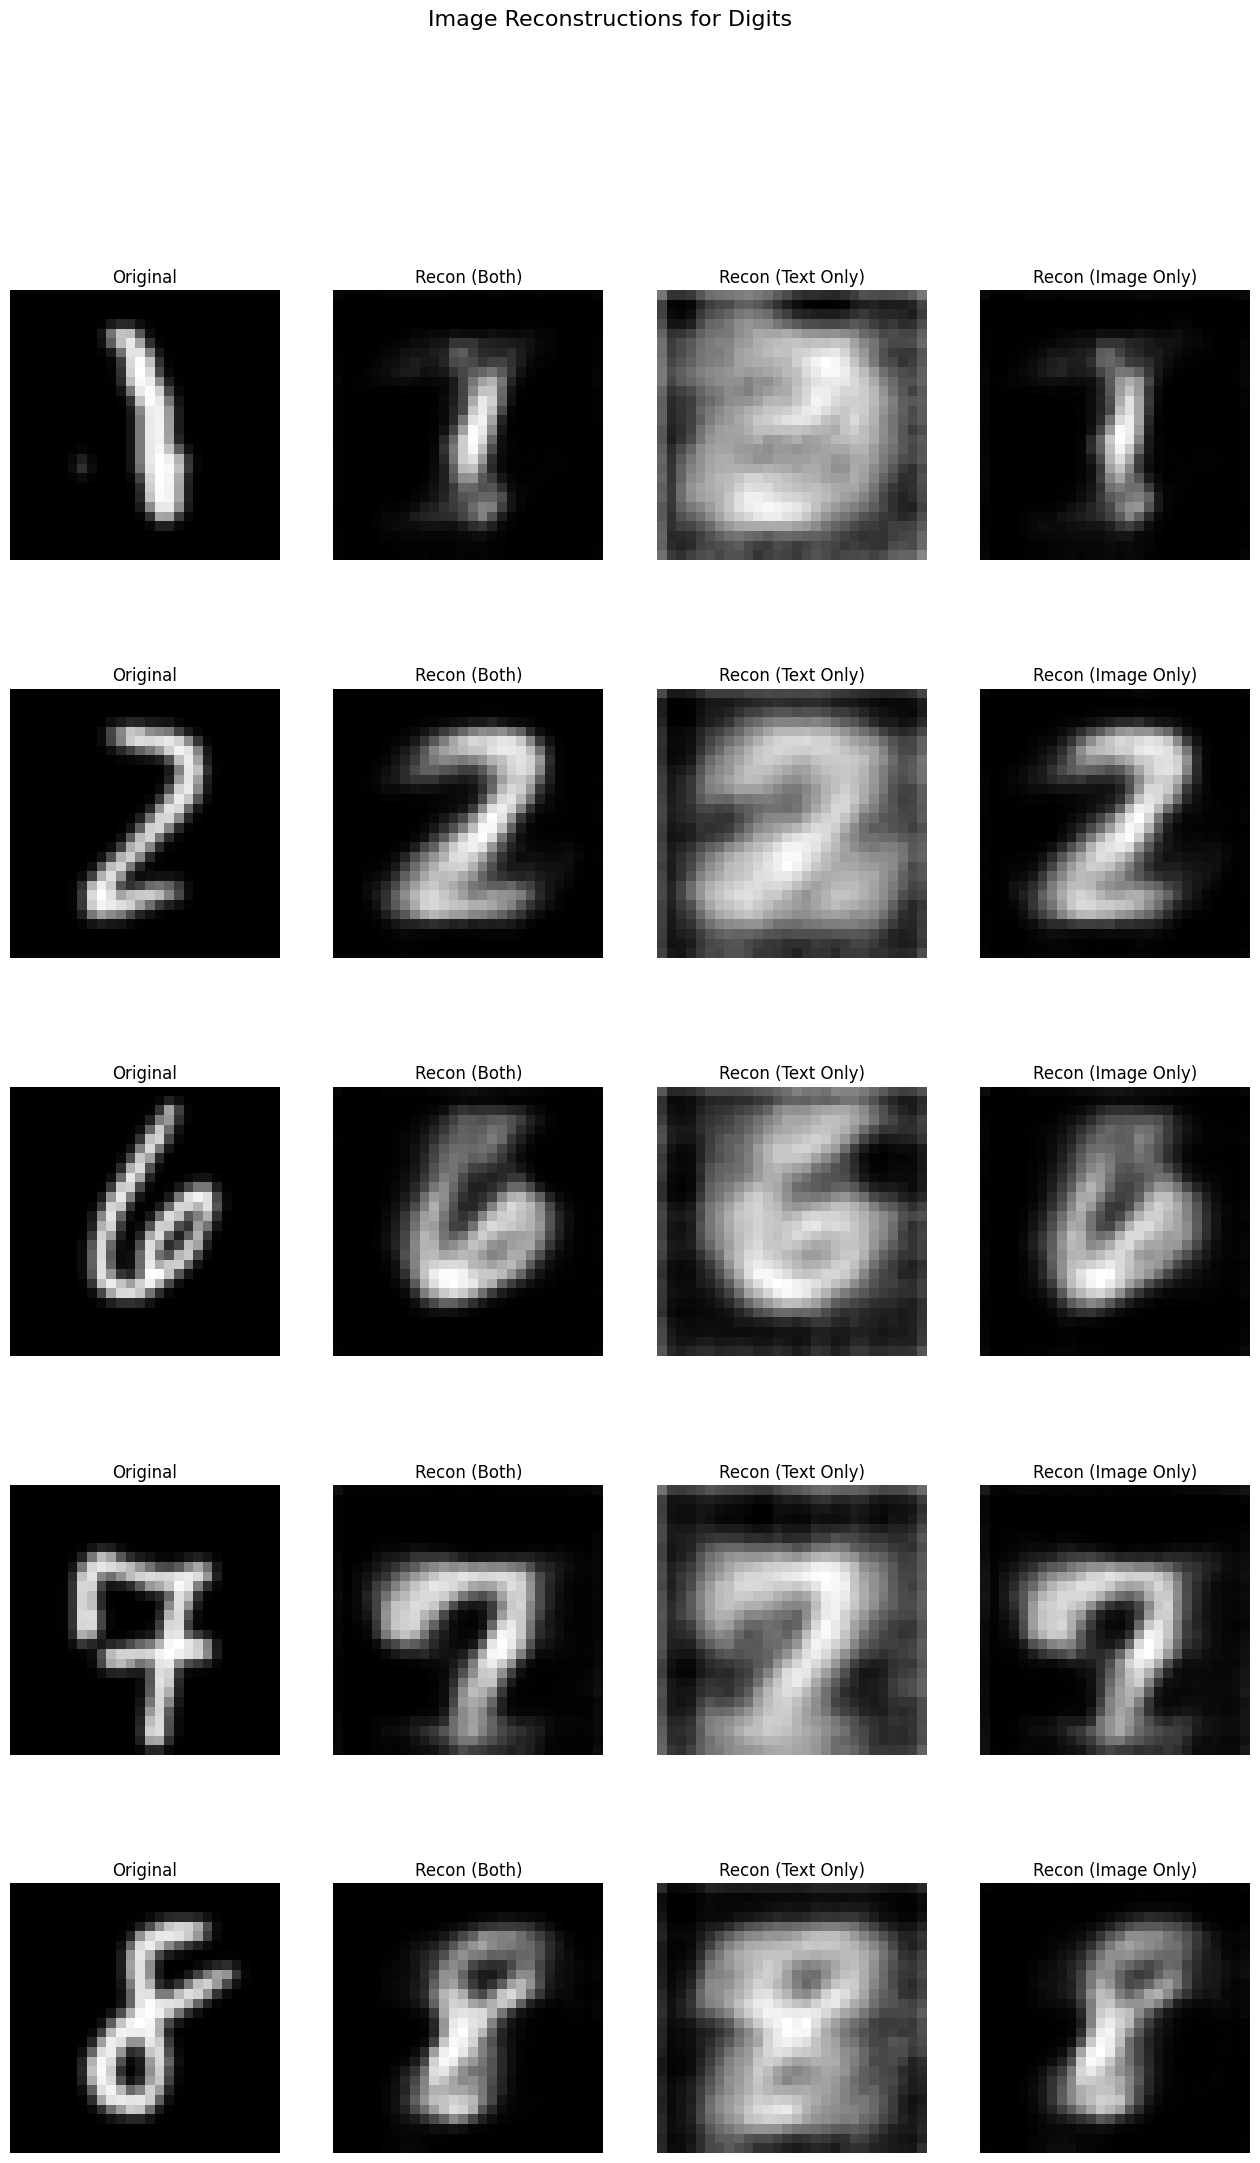

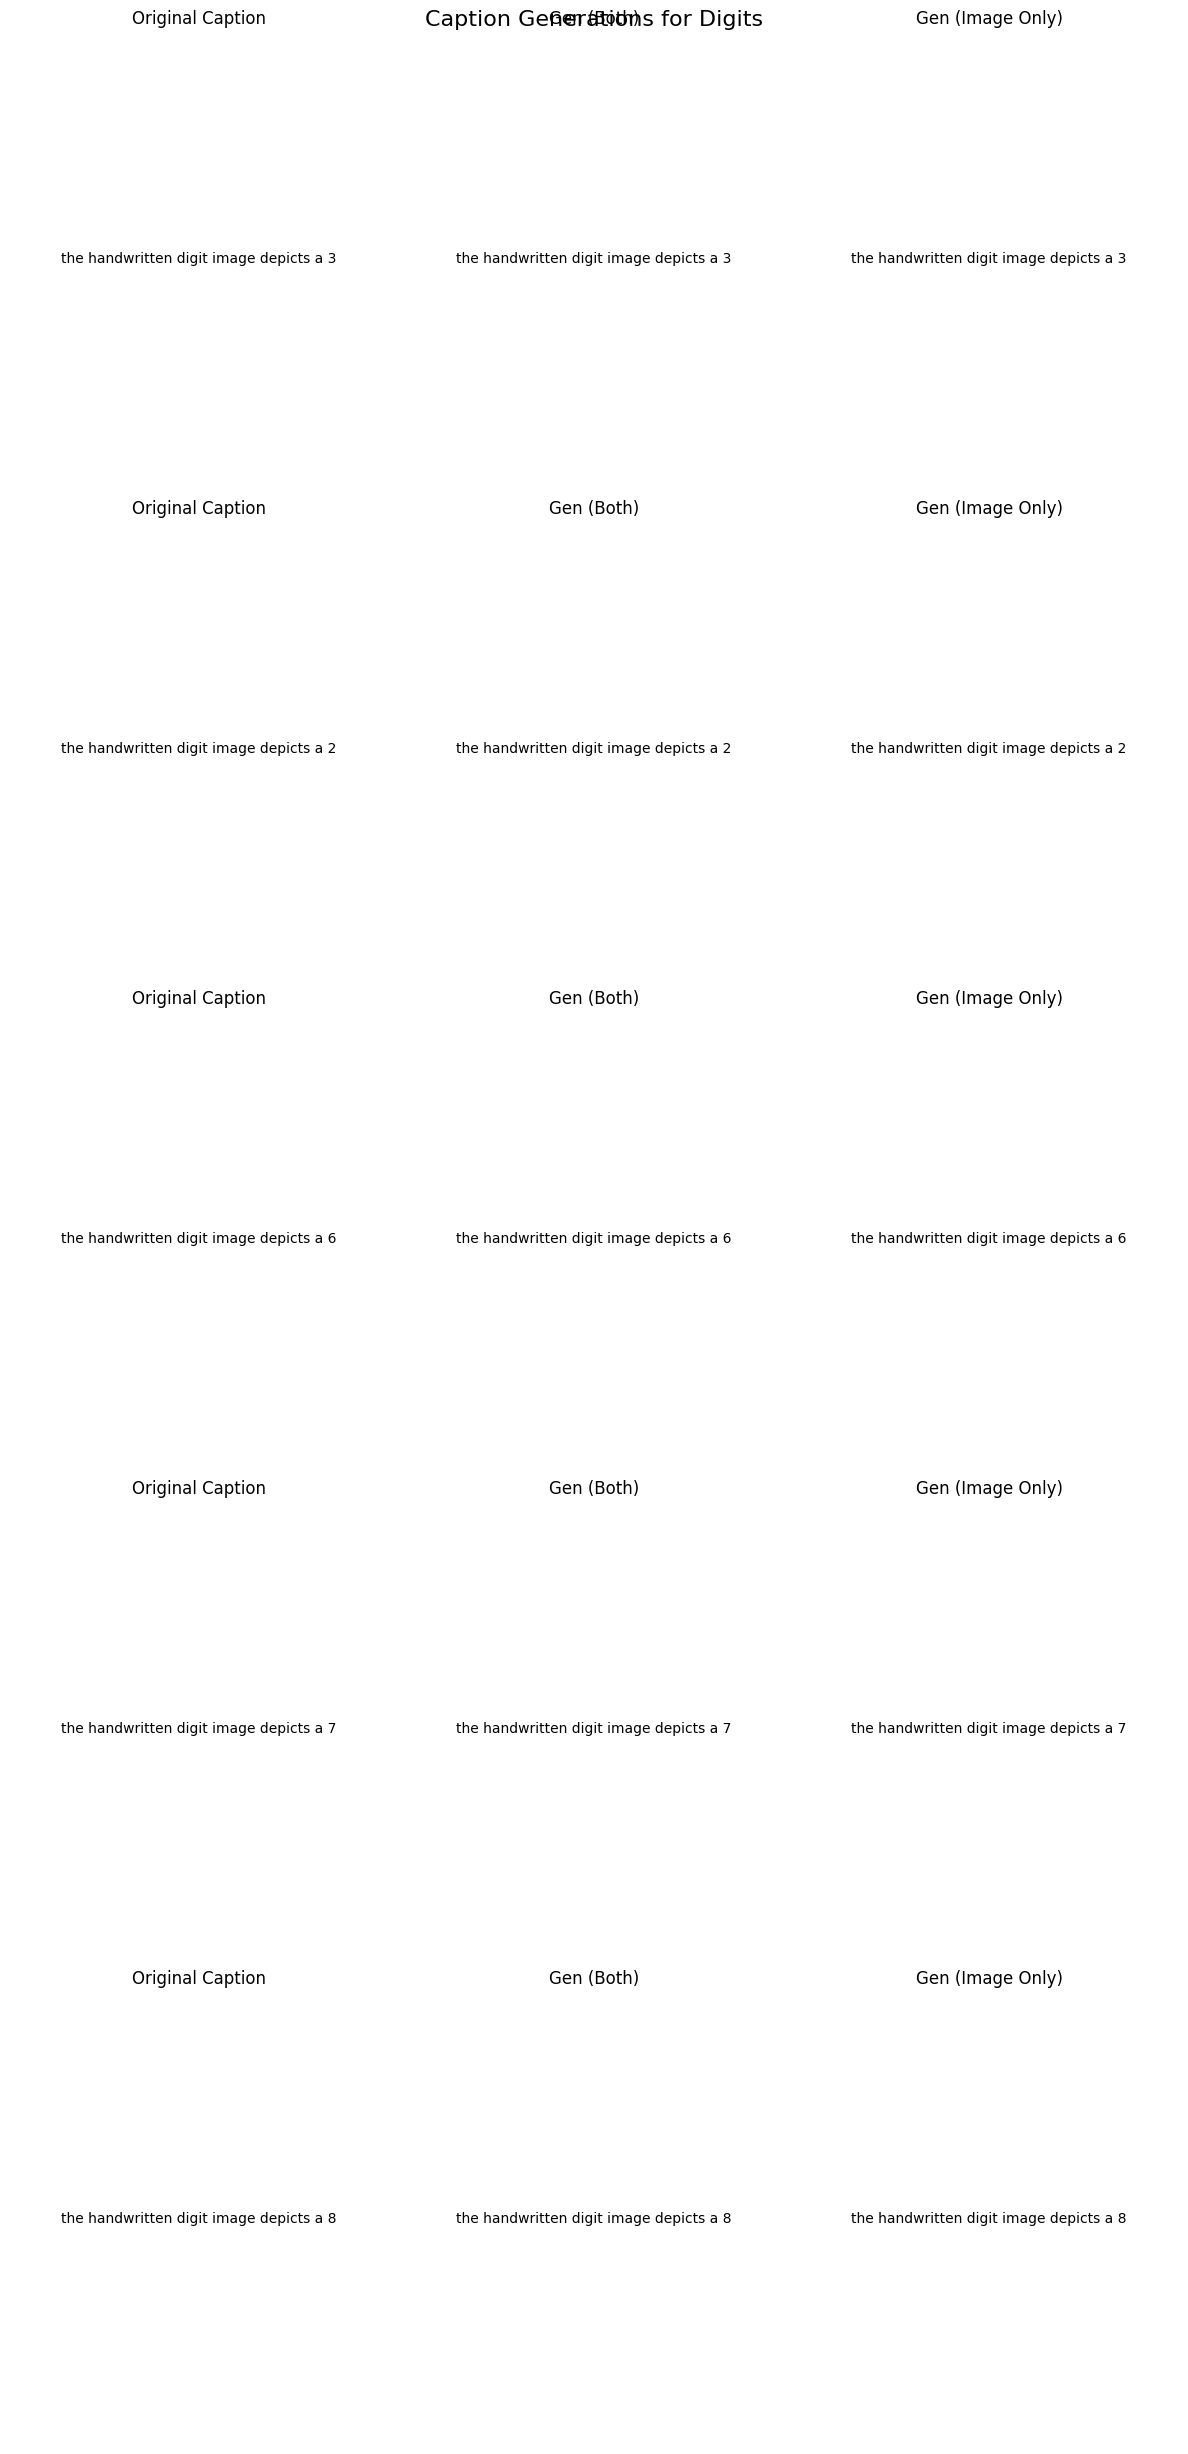

In [60]:
visualize_all_digits_grouped_plots(model, test_dataset, vocab, device=device)


In [61]:
def visualize_text_generations_compact(model, dataset, vocab, device="cuda"):
    import matplotlib.pyplot as plt

    wanted_labels = {0, 3, 4, 5, 9}
    digit_samples = {}
    for i in range(len(dataset)):
        img, txt, label = dataset[i]
        if label not in wanted_labels:
            digit_samples[label] = (img, txt)
        if len(digit_samples) == len(wanted_labels):
            break

    model.eval()

    fig = plt.figure(figsize=(12, 10))
    fig.suptitle("Text Generations for Digits 0–9", fontsize=16, y=0.95)

    line_height = 0.08
    x_positions = [0.1, 0.4, 0.7]  # Original, Gen (Both), Gen (Image Only)

    with torch.no_grad():
        for i, digit in enumerate(sorted(digit_samples.keys())):
            img, txt = digit_samples[digit]
            image = img.unsqueeze(0).to(device)
            text = txt.unsqueeze(0).to(device)

            img_embed = model.image_encoder(image)
            txt_embed = model.text_encoder(text)

            z_both = model.fusion(img_embed, txt_embed)
            z_img = model.fusion(img_embed, torch.zeros_like(txt_embed))

            recon_txt_both = model.text_decoder(z_both).argmax(dim=-1)[0].cpu()
            recon_txt_imgonly = model.text_decoder(z_img).argmax(dim=-1)[0].cpu()

            y_pos = 0.90 - i * line_height
            fig.text(x_positions[0], y_pos, decode_caption(txt.cpu().tolist(), vocab), ha='left', fontsize=10)
            fig.text(x_positions[1], y_pos, decode_caption(recon_txt_both.cpu().tolist(), vocab), ha='left', fontsize=10)
            fig.text(x_positions[2], y_pos, decode_caption(recon_txt_imgonly.cpu().tolist(), vocab), ha='left', fontsize=10)

    # Add column headers
    header_y = 0.92
    fig.text(x_positions[0], header_y, "Original Caption", ha='left', weight='bold')
    fig.text(x_positions[1], header_y, "Gen (Both)", ha='left', weight='bold')
    fig.text(x_positions[2], header_y, "Gen (Image Only)", ha='left', weight='bold')

    plt.axis("off")
    plt.show()


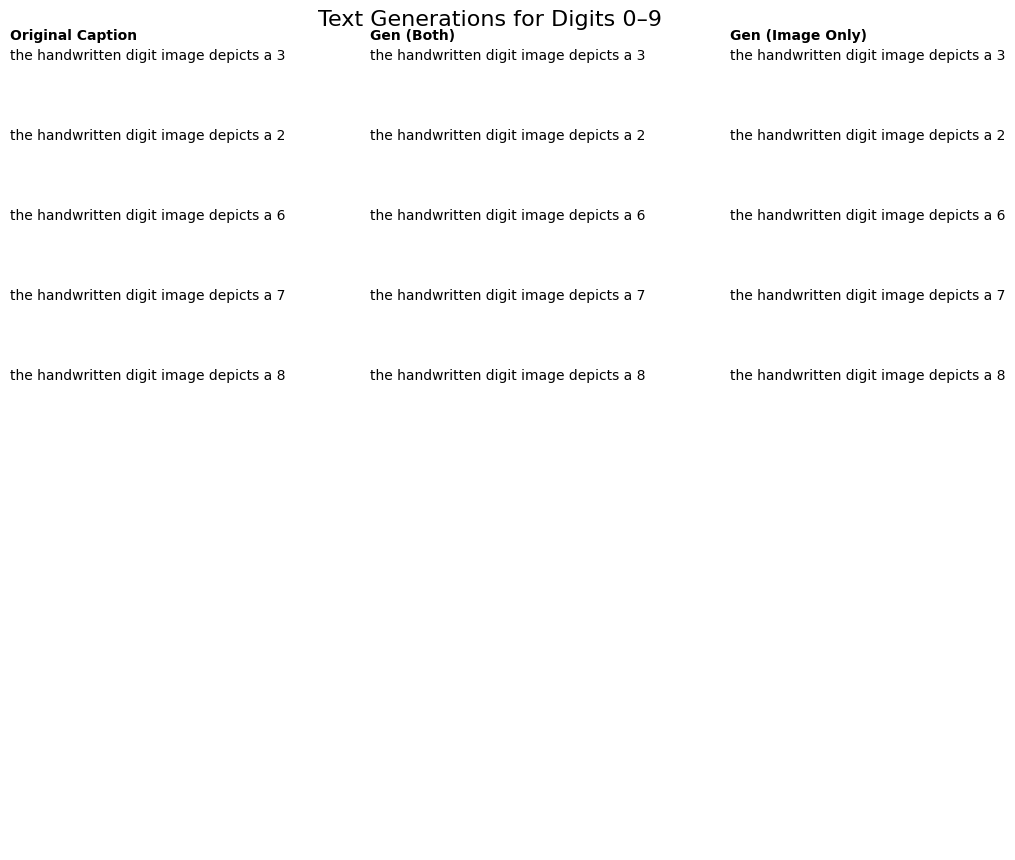

In [62]:
visualize_text_generations_compact(model, test_dataset, vocab, device=device)


In [53]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_latent_space(model, dataloader, device="cuda", num_batches=10):
    model.eval()
    latent_z = []
    labels = []

    with torch.no_grad():
        for i, (image, text, label) in enumerate(dataloader):
            if i >= num_batches:
                break
            image = image.to(device)
            text = text.to(device)

            img_embed = model.image_encoder(image)
            txt_embed = model.text_encoder(text)
            z = model.fusion(img_embed, txt_embed)  # Joint latent space

            latent_z.append(z.cpu().numpy())
            labels.append(label.cpu().numpy())

    # Combine and reduce
    latent_z = np.concatenate(latent_z, axis=0)
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=42)
    z_2d = tsne.fit_transform(latent_z)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap="tab10", alpha=0.7, s=20)
    plt.legend(*scatter.legend_elements(), title="Digits")
    plt.title("t-SNE of Joint Latent Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()


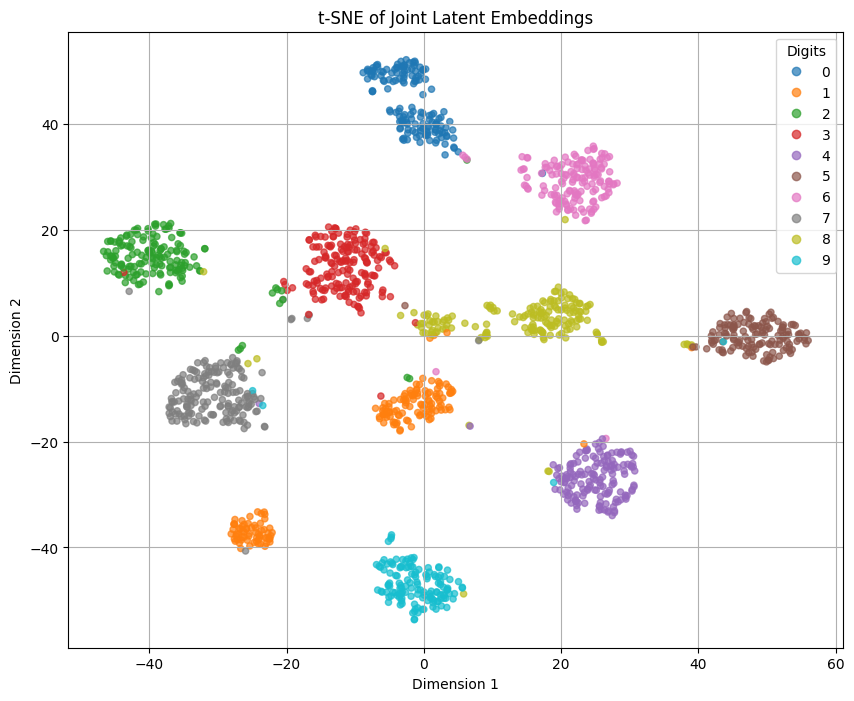

In [54]:
plot_tsne_latent_space(model, test_loader, device=device, num_batches=25)


In [ ]:
from evaluate import load
bleu = load("bleu")

In [ ]:
def evaluate_bleu(model, dataloader, vocab, device="cuda", max_batches=10):
    model.eval()
    predictions = []
    references = []

    inv_vocab = {idx: word for word, idx in vocab.items()}

    def decode(ids):
        return [inv_vocab.get(idx, "<UNK>") for idx in ids if idx != vocab["<PAD>"]]

    with torch.no_grad():
        for i, (image, text, label) in enumerate(dataloader):
            if i >= max_batches:
                break

            image, text = image.to(device), text.to(device)
            z, _, _, recon_text, _, _ = model(image, text)
            recon_ids = recon_text.argmax(dim=-1).cpu()

            for pred_ids, ref_ids in zip(recon_ids, text.cpu()):
                pred_tokens = decode(pred_ids.tolist())
                ref_tokens = decode(ref_ids.tolist())
                predictions.append(" ".join(pred_tokens))
                references.append([" ".join(ref_tokens)])  # Note: list of list for BLEU

    results = bleu.compute(predictions=predictions, references=references)
    print(f"BLEU Score: {results['bleu']:.4f}")
    return results['bleu']

In [ ]:
evaluate_bleu(model, test_loader, vocab, device="cuda", max_batches=10)

BLEU Score: 1.0000


1.0

In [ ]:
!pip install -q scikit-image
from skimage.metrics import structural_similarity as ssim


In [ ]:
def evaluate_ssim(model, dataloader, device="cuda", max_batches=10):
    model.eval()
    total_ssim = 0.0
    count = 0

    with torch.no_grad():
        for i, (image, text, label) in enumerate(dataloader):
            if i >= max_batches:
                break

            image = image.to(device)
            text = text.to(device)

            _, _, recon_img, _, _, _ = model(image, text)

            for real_img, rec_img in zip(image.cpu(), recon_img.cpu()):
                real_img_np = real_img.squeeze().numpy()
                rec_img_np = rec_img.squeeze().numpy()
                score = ssim(real_img_np, rec_img_np, data_range=1.0)
                total_ssim += score
                count += 1

    avg_ssim = total_ssim / count
    print(f"Average SSIM: {avg_ssim:.4f}")
    return avg_ssim

In [ ]:
evaluate_ssim(model, test_loader, device=device)

Average SSIM: 0.5881


np.float64(0.5881307484945796)